# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data is from 17 marketing campaigns conducted between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, the client was offered an attractive long-term deposit application, with good interest rates. Information related to client personal data, bank data, and information related to contact (including past contacts and campaigns) along with the target variable of whether or not the client subsribed to the long-term deposit are available in the dataset.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [211]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

import category_encoders as ce
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [212]:
# Add dataset from csv
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [213]:
# Display head(top 5 rows) of the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [214]:
# Examine the dataset information like datatype and non-null counts for different columns. 
# There are 41188 rows and 21 columns in this dataset, with a couple of numeric(int or float) type columns and 
# several object type columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [215]:
# Does the data have any null values? It does not.
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [216]:
# Does the data have any duplicated values? Yes, a few.
df.duplicated().sum()

12

In [217]:
# Drop the duplicated values.
df=df.drop_duplicates()
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective is to predict whether a customer will or will not subscribe to the long-term deposit application


This is a classification problem

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [218]:
# Select the personal/bank information columns from the data and map the target variables to 0s and 1s
x=df[df.columns[0:7]]
y=df['y'].map({'no':0,'yes':1})
x

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes
...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no
41184,46,blue-collar,married,professional.course,no,no,no
41185,56,retired,married,university.degree,no,yes,no
41186,44,technician,married,professional.course,no,no,no


0    0.887337
1    0.112663
Name: y, dtype: float64
----------------------------------

----------Count of clients that subsribed (1) or did not subsribe (0)-----


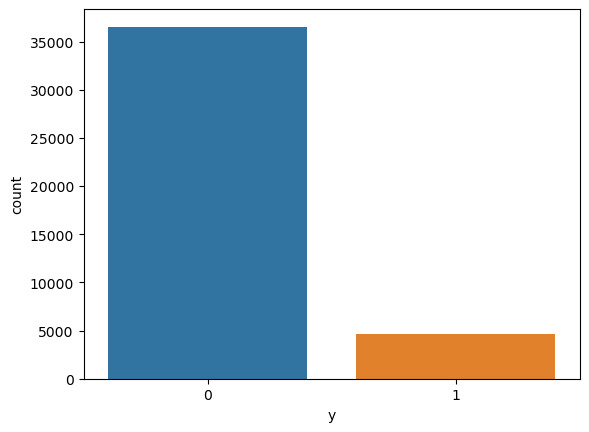

In [229]:
# Plot proportion of y: subsribed or not
print(y.value_counts(normalize=True))
print('----------------------------------\n')
print('----------Count of clients that subsribed (1) or did not subsribe (0)-----')
sns.countplot(y)
plt.show()
#plt.title('Count of clients that subsribed (1) or did not subsribe (0)')

# The data is imbalanced as there are about 89% of non-subsribers ans 11% of subsribers

In [230]:
# Encoding the data
encoder=ce.LeaveOneOutEncoder(return_df=True)
X=encoder.fit_transform(x,y)
X

,age,job,marital,education,default,housing,loan
0,56,0.100094,0.101565,0.102515,0.128806,0.108789,0.113416
1,57,0.081442,0.101565,0.108401,0.051542,0.108789,0.113416
2,37,0.081442,0.101565,0.108401,0.128806,0.116226,0.113416
3,40,0.129679,0.101565,0.082096,0.128806,0.108789,0.113416
4,56,0.081442,0.101565,0.108401,0.128806,0.108789,0.109332
...,...,...,...,...,...,...,...
41183,73,0.252184,0.101525,0.113380,0.128776,0.116180,0.113387
41184,46,0.068958,0.101565,0.113571,0.128806,0.108789,0.113416
41185,56,0.252766,0.101565,0.137219,0.128806,0.116226,0.113416
41186,44,0.108192,0.101525,0.113380,0.128776,0.108735,0.113387


<AxesSubplot:>

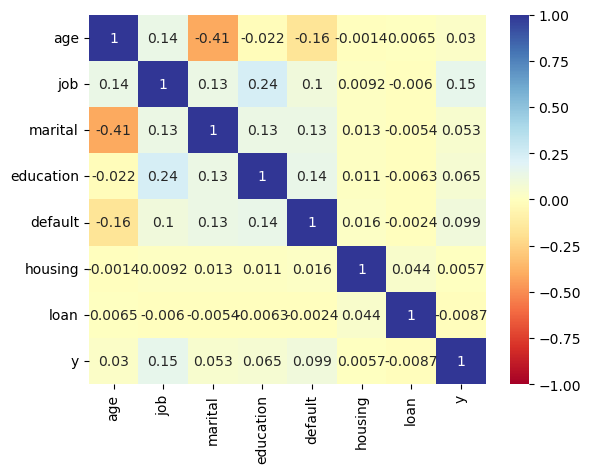

In [231]:
# Plot correlation matrix to view correlations with target variable as well as correlation amongst various features
# Correlations are all below <0.5, so multicollinearity is minimal
d=X
d['y']=y
sns.heatmap(d.corr(),vmin=-1,vmax=1,annot=True,cmap='RdYlBu')

In [232]:
X=X.drop(columns=['y'])

In [233]:
# Balance the dataset using the SMOTE oversampler
oversampler=SMOTE(random_state=42)
X_bal,y_bal=oversampler.fit_resample(X,y)
X_bal

,age,job,marital,education,default,housing,loan
0,56,0.100094,0.101565,0.102515,0.128806,0.108789,0.113416
1,57,0.081442,0.101565,0.108401,0.051542,0.108789,0.113416
2,37,0.081442,0.101565,0.108401,0.128806,0.116226,0.113416
3,40,0.129679,0.101565,0.082096,0.128806,0.108789,0.113416
4,56,0.081442,0.101565,0.108401,0.128806,0.108789,0.109332
...,...,...,...,...,...,...,...
73069,43,0.093196,0.101525,0.137137,0.051425,0.110166,0.113387
73070,35,0.129583,0.101525,0.137137,0.128776,0.108735,0.113387
73071,36,0.076570,0.101525,0.140923,0.128776,0.108735,0.113387
73072,28,0.129583,0.140016,0.108296,0.128776,0.108735,0.113387


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [234]:
# The data is normalized using StandardScaler() after the train-test split

In [235]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=42)

In [236]:
X_train=StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)

In [237]:
X_train_bal,X_test_bal,y_train_bal,y_test_bal=train_test_split(X_bal,y_bal,test_size=0.20,stratify=y_bal,random_state=42)

In [238]:
X_train_bal=StandardScaler().fit_transform(X_train_bal)
X_test_bal=StandardScaler().fit_transform(X_test_bal)

After this, Models are run using the balanced dataset (that has been split into train & test samples, and then normalized/scaled)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [239]:
pip install time

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [240]:
import time

In [241]:
# Dummy Classifier
start=time.time()
dummy_bal=DummyClassifier(random_state=42).fit(X_train_bal,y_train_bal)
end=time.time()
dummy_time=end-start
print(dummy_time)

print('Train and test accuracy')
dummy_train_acc_bal=accuracy_score(y_train_bal,dummy_bal.predict(X_train_bal))
print(dummy_train_acc_bal)
dummy_test_acc_bal=accuracy_score(y_test_bal,dummy_bal.predict(X_test_bal))
print(dummy_test_acc_bal)
print('Train and test F-1 score')
dummy_train_f1_bal=f1_score(y_train_bal,dummy_bal.predict(X_train_bal))
print(dummy_train_f1_bal)
dummy_test_f1_bal=f1_score(y_test_bal,dummy_bal.predict(X_test_bal))
print(dummy_test_f1_bal)
print('------------Classification Report-------------')
print(classification_report(y_test_bal,dummy_bal.predict(X_test_bal)))

0.0030007362365722656
Train and test accuracy
0.5000085530029593
0.49996578857338353
Train and test F-1 score
0.6666742692926138
0.6666362558160752
------------Classification Report-------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7308
           1       0.50      1.00      0.67      7307

    accuracy                           0.50     14615
   macro avg       0.25      0.50      0.33     14615
weighted avg       0.25      0.50      0.33     14615



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [247]:
# Logistic Regression
start=time.time()
log_bal=LogisticRegression(random_state=42).fit(X_train_bal,y_train_bal)
end=time.time()
log_time=end-start
print(log_time)

print('Train and test accuracy')
log_train_acc_bal=accuracy_score(y_train_bal,log_bal.predict(X_train_bal))
print(log_train_acc_bal)
log_test_acc_bal=accuracy_score(y_test_bal,log_bal.predict(X_test_bal))
print(log_test_acc_bal)
print('Train and test F-1 score')
log_train_f1_bal=f1_score(y_train_bal,log_bal.predict(X_train_bal))
print(log_train_f1_bal)
log_test_f1_bal=f1_score(y_test_bal,log_bal.predict(X_test_bal))
print(log_test_f1_bal)
print('------------Classification Report-------------')
print(classification_report(y_test_bal,log_bal.predict(X_test_bal)))

0.040609121322631836
Train and test accuracy
0.6076224362373629
0.6075265138556277
Train and test F-1 score
0.6288950008089306
0.6283048211508553
------------Classification Report-------------
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      7308
           1       0.60      0.66      0.63      7307

    accuracy                           0.61     14615
   macro avg       0.61      0.61      0.61     14615
weighted avg       0.61      0.61      0.61     14615



### Problem 9: Score the Model

What is the accuracy of your model?

The accuracy score of the Logisitic Regression model is 61% for the test data (and 62% for the training data).

However, F-1 score is chosen as a better score as it maximizes both recall and precision, as it would be preferable to minimize both false negatives (where an actual subsriber is predicted as non-subscribed--this scenario can lead to loss of potential important clients/subsribers) and false positives (where an actual non-subsriber is predicted as subscribed--this scenario can lead to a waste of time and resources).
The F-1 score of this Logistic Regression model is 62.8% for the test data (and 63% for the training data).

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [248]:
# K Nearest Neighbors (KNN)
start=time.time()
knn_bal=KNeighborsClassifier().fit(X_train_bal,y_train_bal)
end=time.time()
knn_time=end-start
print(knn_time)

print('Train and test accuracy')
knn_train_acc_bal=accuracy_score(y_train_bal,knn_bal.predict(X_train_bal))
print(knn_train_acc_bal)
knn_test_acc_bal=accuracy_score(y_test_bal,knn_bal.predict(X_test_bal))
print(knn_test_acc_bal)
print('Train and test F-1 score')
knn_train_f1_bal=f1_score(y_train_bal,knn_bal.predict(X_train_bal))
print(knn_train_f1_bal)
knn_test_f1_bal=f1_score(y_test_bal,knn_bal.predict(X_test_bal))
print(knn_test_f1_bal)
print('------------Classification Report-------------')
print(classification_report(y_test_bal,knn_bal.predict(X_test_bal)))

0.16911101341247559
Train and test accuracy
0.9467147915633178
0.9097502565856996
Train and test F-1 score
0.9456189661493339
0.9074970194263271
------------Classification Report-------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7308
           1       0.93      0.89      0.91      7307

    accuracy                           0.91     14615
   macro avg       0.91      0.91      0.91     14615
weighted avg       0.91      0.91      0.91     14615



In [252]:
# Decision Tree
start=time.time()
tree_bal=DecisionTreeClassifier(random_state=42).fit(X_train_bal,y_train_bal)
end=time.time()
tree_time=end-start
print(tree_time)

print('Train and test accuracy')
tree_train_acc_bal=accuracy_score(y_train_bal,tree_bal.predict(X_train_bal))
print(tree_train_acc_bal)
tree_test_acc_bal=accuracy_score(y_test_bal,tree_bal.predict(X_test_bal))
print(tree_test_acc_bal)
print('Train and test F-1 score')
tree_train_f1_bal=f1_score(y_train_bal,tree_bal.predict(X_train_bal))
print(tree_train_f1_bal)
tree_test_f1_bal=f1_score(y_test_bal,tree_bal.predict(X_test_bal))
print(tree_test_f1_bal)
print('------------Classification Report-------------')
print(classification_report(y_test_bal,tree_bal.predict(X_test_bal)))

0.051764488220214844
Train and test accuracy
1.0
0.959630516592542
Train and test F-1 score
1.0
0.9611944225203893
------------Classification Report-------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      7308
           1       0.93      1.00      0.96      7307

    accuracy                           0.96     14615
   macro avg       0.96      0.96      0.96     14615
weighted avg       0.96      0.96      0.96     14615



In [253]:
# Support Vector Machines (SVM)
start=time.time()
svm_bal=SVC(random_state=42).fit(X_train_bal,y_train_bal)
end=time.time()
svm_time=end-start
print(svm_time)

print('Train and test accuracy')
svm_train_acc_bal=accuracy_score(y_train_bal,svm_bal.predict(X_train_bal))
print(svm_train_acc_bal)
svm_test_acc_bal=accuracy_score(y_test_bal,svm_bal.predict(X_test_bal))
print(svm_test_acc_bal)
print('Train and test F-1 score')
svm_train_f1_bal=f1_score(y_train_bal,svm_bal.predict(X_train_bal))
print(svm_train_f1_bal)
svm_test_f1_bal=f1_score(y_test_bal,svm_bal.predict(X_test_bal))
print(svm_test_f1_bal)
print('------------Classification Report-------------')
print(classification_report(y_test_bal,svm_bal.predict(X_test_bal)))

267.18292927742004
Train and test accuracy
0.7603277510734019
0.7649674991447143
Train and test F-1 score
0.7420322942941836
0.7449699309525578
------------Classification Report-------------
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      7308
           1       0.81      0.69      0.74      7307

    accuracy                           0.76     14615
   macro avg       0.77      0.76      0.76     14615
weighted avg       0.77      0.76      0.76     14615



In [254]:
# Dataframe containing scores and fit times for all the classifiers

all1 = {'Classifiers': [ 'Dummy', 'Logistic Regression', 'KNN','Decision Tree', 'SVM'],\
        'Train Time(sec)': [dummy_time,log_time,knn_time,tree_time,svm_time],\
        'Train accuracy': [dummy_train_acc_bal,log_train_acc_bal,knn_train_acc_bal,tree_train_acc_bal,svm_train_acc_bal],\
        'Test accuracy': [dummy_test_acc_bal,log_test_acc_bal,knn_test_acc_bal,tree_test_acc_bal,svm_test_acc_bal],\
        'Train F1 score': [dummy_train_f1_bal,log_train_f1_bal,knn_train_f1_bal,tree_train_f1_bal,svm_train_f1_bal],\
        'Test F1 score': [dummy_test_f1_bal,log_test_f1_bal,knn_test_f1_bal,tree_test_f1_bal,svm_test_f1_bal]}
df1 = pd.DataFrame(all1).set_index('Classifiers')
pd.set_option('max_colwidth', None)
df1

,Train Time(sec),Train accuracy,Test accuracy,Train F1 score,Test F1 score
Classifiers,,,,,
Dummy,0.003001,0.500009,0.499966,0.666674,0.666636
Logistic Regression,0.040609,0.607622,0.607527,0.628895,0.628305
KNN,0.169111,0.946715,0.909750,0.945619,0.907497
Decision Tree,0.051764,1.000000,0.959631,1.000000,0.961194
SVM,267.182929,0.760328,0.764967,0.742032,0.744970


Model Performance Discussion:

In terms of train as well as test accuracy, KNN and decision tree performed best. Their test scores were 90% for KNN and 95.9% for Decision Trees. All models had a test accuracy higher than test accuracy of dummy classifier (50%). 
However, the test F-1 scores were not always high, e.g., Logistic regression which had the lowest test F-1 score(62%) of all models except dummy classifier (which had F1 score of 66%). KNN and Decision trees had the highest F-1 score of 90% and 96%, respectively.
In terms of time, Logisitic Regression and Decision Trees were the fastest, followed by KNN. SVM took substantiall longer than all others.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----------
------------
{'C': 0.13894954943731375, 'penalty': 'l2'}
0.018835681676864623
0.6288608086462698
0.6283048211508553
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      7308
           1       0.60      0.66      0.63      7307

    accuracy                           0.61     14615
   macro avg       0.61      0.61      0.61     14615
weighted avg       0.61      0.61      0.61     14615

0.656482911580763


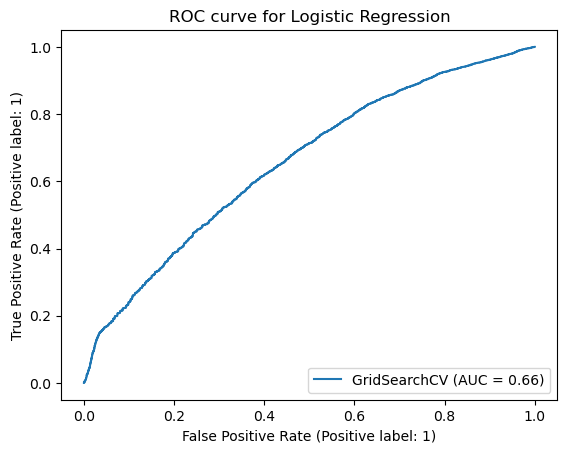

In [244]:
# Logistic Regression
log1 = GridSearchCV(LogisticRegression(max_iter=1000),\
                    param_grid = { 'penalty':['l1','l2'], 'C': np.logspace(-4,4,16)},\
                    scoring = 'f1',\
                    verbose = 1,\
                    return_train_score = True ).fit(X_train_bal,y_train_bal) # F1 score is used in 'scoring' of GridSearchCV
print('-----------')
#print(log1.cv_results_)
print('------------')
print(log1.best_params_)

# Mean fit time
print(np.mean(log1.cv_results_['mean_fit_time']))

# F-scores for train and test data
print(log1.score(X_train_bal,y_train_bal))
print(log1.score(X_test_bal,y_test_bal))
#Classification report for more information
print(classification_report(y_test_bal, log1.predict(X_test_bal)))

#Besides F1 score, ROC AUC is also obtained as a performance metric
plot_roc_curve(log1, X_test_bal, y_test_bal)
plt.title('ROC curve for Logistic Regression')
print(roc_auc_score(y_test_bal, log1.decision_function(X_test_bal))) #ROCcurve shows a lower performance level,with AUC=0.66

Additionally, the paper by Moro&Laureno metioned Cumulative Gains/Lift curve as a commonly used metric in marketing campaigns, so this is also plotted for each model.

In [113]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


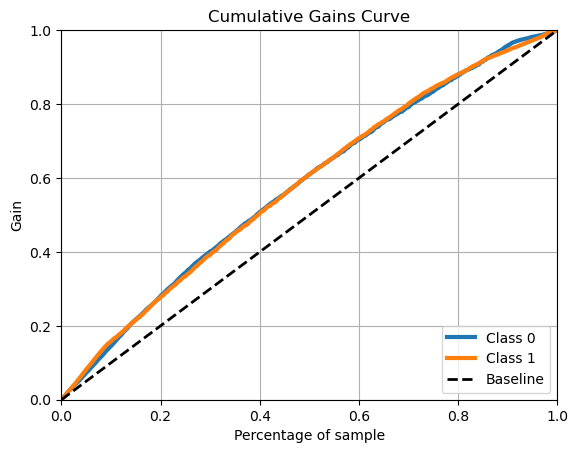

In [114]:
# Cumulative gains plot for logistic regression

# The curve shows for a given sampling % of clients, if the model will get more subscribers than random sampling (baseline).
# For logistic regression, sampling 50% of the clients could get 60% subsribers (which is slighlty better than random sampling,
# where sampling 50% of the clients could get 50% subsribers)
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test_bal, log1.predict_proba(X_test_bal))
plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
-----------
------------
{'n_neighbors': 1}
0.17281284332275393
1.0
0.9504692745084606
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7308
           1       0.95      0.95      0.95      7307

    accuracy                           0.95     14615
   macro avg       0.95      0.95      0.95     14615
weighted avg       0.95      0.95      0.95     14615

0.9505301972922771


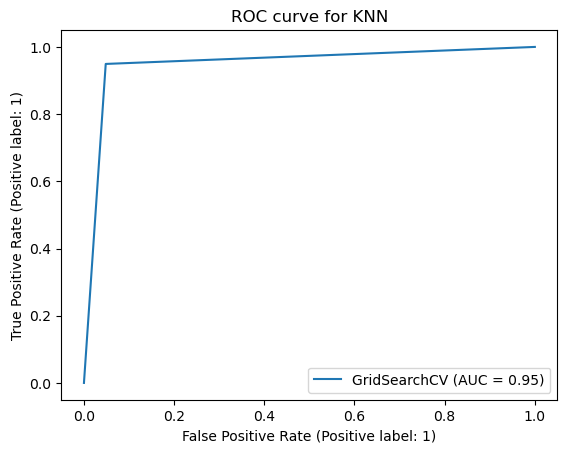

In [245]:
# KNN
knn1 = GridSearchCV(KNeighborsClassifier(),\
                    param_grid = { 'n_neighbors' : range( 1, 10 )},\
                    scoring = 'f1',\
                    verbose = 1,\
                    return_train_score = True ).fit(X_train_bal,y_train_bal)
print('-----------')
#print(knn1.cv_results_)
print('------------')
print(knn1.best_params_)

# Mean fit time
print(np.mean(knn1.cv_results_['mean_fit_time']))

# F-1 scores for train and test data
print(knn1.score(X_train_bal,y_train_bal))
print(knn1.score(X_test_bal,y_test_bal))
print(classification_report(y_test_bal, knn1.predict(X_test_bal)))

# ROC curve and AUC
plot_roc_curve(knn1, X_test_bal, y_test_bal)
plt.title('ROC curve for KNN')
#print(roc_auc_score(y_test_bal, knn1.decision_function(X_test_bal)))
print(roc_auc_score(y_test_bal, knn1.predict_proba(X_test_bal)[:, 1]))#ROCcurve shows a high performance level,with AUC=0.95

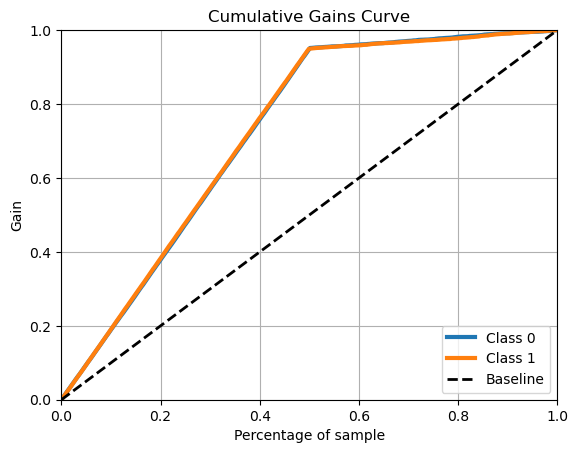

In [115]:
#Cumulative gains plot for KNN

# For KNN, sampling 50% of the clients could get more than 90% subsribers (which is better than random sampling,
# where sampling 50% of the clients could get 50% subsribers)
skplt.metrics.plot_cumulative_gain(y_test_bal, knn1.predict_proba(X_test_bal))
plt.show()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
-----------
------------
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.03962405174970627
1.0
0.9611944225203893
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      7308
           1       0.93      1.00      0.96      7307

    accuracy                           0.96     14615
   macro avg       0.96      0.96      0.96     14615
weighted avg       0.96      0.96      0.96     14615

0.9596332785987958


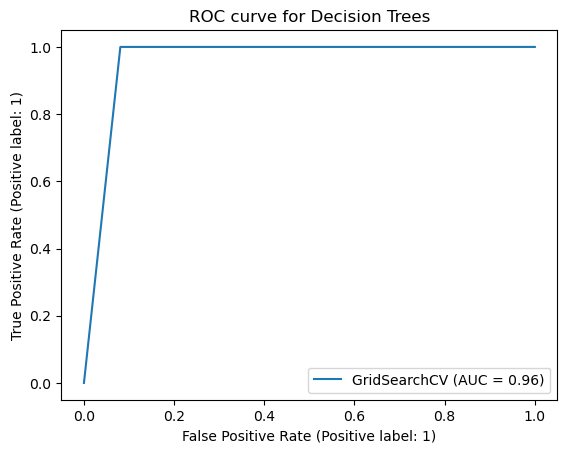

In [255]:
# Decision Trees
params = {'max_depth': range(1,16),
         'min_samples_split': [2,4,6,8],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [1,2,3,4]
         }
tree1= GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, scoring = 'f1',\
                    verbose = 1,\
                    return_train_score = True).fit(X_train_bal, y_train_bal)
print('-----------')
#print(tree1.cv_results_)
print('------------')
print(tree1.best_params_)

#Mean fit time
print(np.mean(tree1.cv_results_['mean_fit_time']))

# F-1 scores for train and test data
print(tree1.score(X_train_bal,y_train_bal))
print(tree1.score(X_test_bal,y_test_bal))
print(classification_report(y_test_bal, tree1.predict(X_test_bal)))

# ROC curve and AUC
plot_roc_curve(tree1, X_test_bal, y_test_bal)
plt.title('ROC curve for Decision Trees')
print(roc_auc_score(y_test_bal, tree1.predict_proba(X_test_bal)[:, 1]))#ROC shows a high performance level,with AUC=0.96

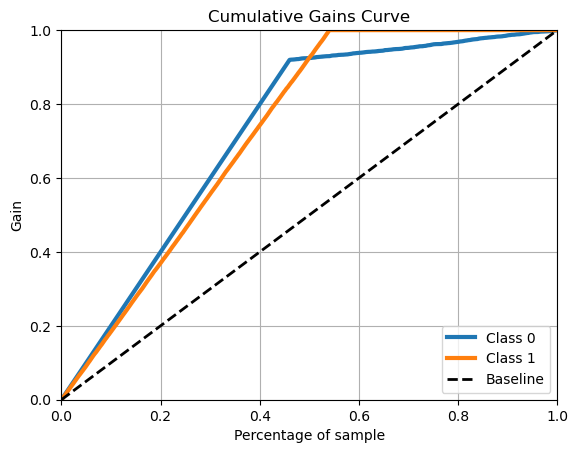

In [256]:
# Cumulative gains plot for Decision trees

# For decision trees, sampling 50% of the clients could get about 95% subsribers (which is better than random sampling,
# where sampling 50% of the clients could get 50% subsribers)
skplt.metrics.plot_cumulative_gain(y_test_bal, tree1.predict_proba(X_test_bal))
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
-----------
------------
{'C': 1.0, 'kernel': 'sigmoid'}
25.574157559871676
0.25006746909915256
0.25406394660350956
              precision    recall  f1-score   support

           0       0.52      0.89      0.65      7308
           1       0.60      0.16      0.25      7307

    accuracy                           0.53     14615
   macro avg       0.56      0.53      0.45     14615
weighted avg       0.56      0.53      0.45     14615

0.5129462874185695


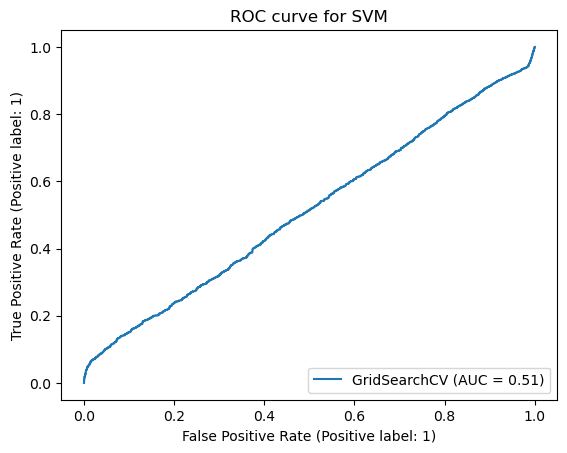

In [204]:
# SVM

params = { 'C' : [ 0.5, 1.0, 1.5 ],\
          'kernel' : [ 'linear', 'poly', 'rbf', 'sigmoid' ]} # 'degree' : range( 1, 3 )}
          #'gamma'  : [ 'scale', 'auto', 0.1, 0.5, 0.75 ] }

# The following code with 'probability=True' in SVC() is needed to get probability values in predict.proba method of SVC(), 
# however it kep trunning for more than 2 hours, so it was stopped and the default SVC() with 
# default probability of False was run to save time
# svm1 = GridSearchCV(SVC(probability=True),param_grid = params,scoring = 'f1',verbose=1,return_train_score = True ).fit(X_train,y_train)

svm1 = GridSearchCV(SVC(),param_grid = params,\
                    scoring = 'f1',\
                    verbose=1,\
                    return_train_score = True ).fit(X_train,y_train)
print('-----------')
#print(svm1.cv_results_)
print('------------')
print(svm1.best_params_)

#Mean fit time
print(np.mean(svm1.cv_results_['mean_fit_time']))

# F-1 scores for train and test data
print(svm1.score(X_train_bal,y_train_bal))
print(svm1.score(X_test_bal,y_test_bal))
print(classification_report(y_test_bal, svm1.predict(X_test_bal)))

# ROC curve and AUC
plot_roc_curve(svm1, X_test_bal, y_test_bal)
plt.title('ROC curve for SVM')
print(roc_auc_score(y_test_bal, svm1.decision_function(X_test_bal)))#ROCcurve shows lowest performance level,with AUC=0.51

In [ ]:
# Cumulative gains plot is skipped for SVM as it needs predict_proba, which is only obtained by setting probability=true 
# in SVC() and that kept running for more than two hours. 
# Regardless, since the SVM AUC and F-1 scores are pretty low, cumulative gains plot is not necessary

#skplt.metrics.plot_cumulative_gain(y_test_bal, svm1.predict_proba(X_test_bal))
#plt.show()

# Best Model

In [263]:
# Combined dataframe containing F1 scores, AUC scores and mean fit times for all the 
# classifiers hyperparamertized using GridSearchCV

all2 = {'Classifiers': [ 'Logistic Regression', 'KNN','Decision Tree', 'SVM'],\
        'Mean Fit Time(min)': [0.02,0.18,0.04,25.6],\
        'Test F1 score': [0.61,0.95,0.96,0.25],\
        'Test ROC AUC': [0.66,0.95,0.96,0.51],\
       'Hyperparameters': [log1.best_params_,knn1.best_params_,tree1.best_params_,svm1.best_params_]}
df2 = pd.DataFrame(all2).set_index('Classifiers')
pd.set_option('max_colwidth', None)
df2

,Mean Fit Time(min),Test F1 score,Test ROC AUC,Hyperparameters
Classifiers,,,,
Logistic Regression,0.02,0.61,0.66,"{'C': 0.13894954943731375, 'penalty': 'l2'}"
KNN,0.18,0.95,0.95,{'n_neighbors': 1}
Decision Tree,0.04,0.96,0.96,"{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}"
SVM,25.60,0.25,0.51,"{'C': 1.0, 'kernel': 'sigmoid'}"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Test F1 score for hyperparameterized models')

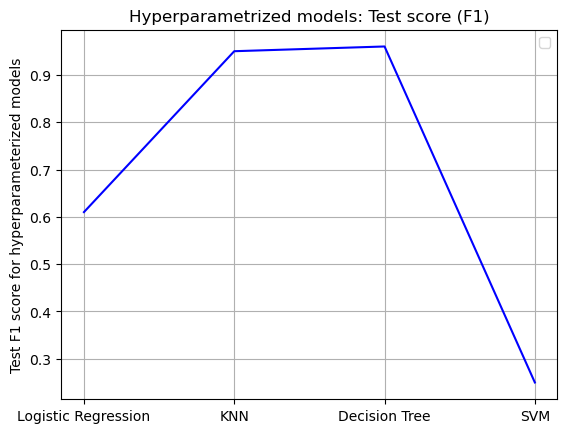

In [258]:
plt.plot(df2['Test F1 score'], 'b-')
plt.grid()
plt.legend()
plt.title('Hyperparametrized models: Test score (F1)')
plt.ylabel('Test F1 score for hyperparameterized models')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Test ROC AUC for hyperparameterized models')

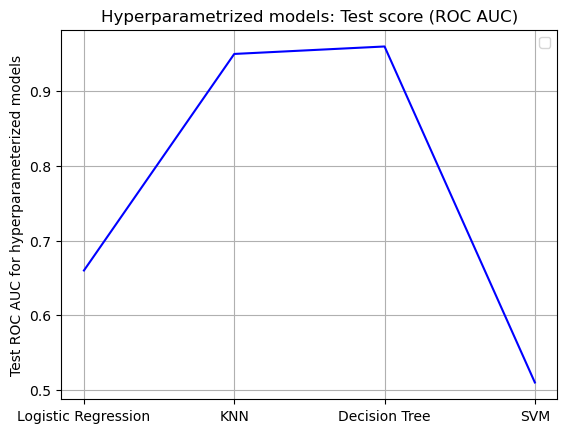

In [261]:
plt.plot(df2['Test ROC AUC'], 'b-')
plt.grid()
plt.legend()
plt.title('Hyperparametrized models: Test score (ROC AUC)')
plt.ylabel('Test ROC AUC for hyperparameterized models')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Time (min) to run for hyperparameterized models')

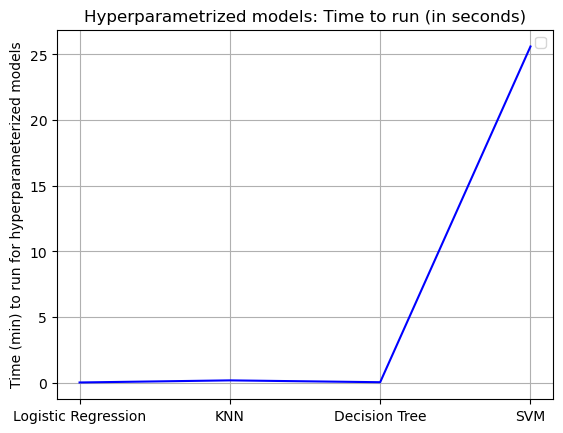

In [262]:
plt.plot(df2['Mean Fit Time(min)'], 'b-')
plt.grid()
plt.legend()
plt.title('Hyperparametrized models: Time to run (in seconds)')
plt.ylabel('Time (min) to run for hyperparameterized models')

Hyperparameterized Models' Performace Discussion:

Decision Tree classifer performed best in terms of both F-1 test score and ROC AUC, followed closely by KNN model. These two models also were the fastest to fit/run. Their F-1 scores were 96%(Decision trees) and 95%(KNN), and their AUCs were 0.96(Decision Trees) and 0.95(KNN). Decision tree was fit/run faster than KNN.

The other two models (Logistic & SVM) did not really improve from their non-hyperparameterized verions, and SVM was very computationally inefficient (took about half an hour to fit wher SVC(probability=False) and atleast two hours when probability=True).

Lastly, in terms of Cumulative gain curves, Decision Trees followed by KNN were the best. For decision trees, sampling 50% of the clients could get about 95% subsribers and for For KNN, sampling 50% of the clients could get more than 90% subsribers.

Based on these several performance indicators/metrics, Decision Trees is the best model. There it is explored further below in terms of feature importance.

DecisionTreeClassifier(max_depth=6, random_state=42)
[0.         0.         0.         0.         0.25484588 0.03575506
 0.70939906]


Text(0, 0.5, 'Relative feature importance')

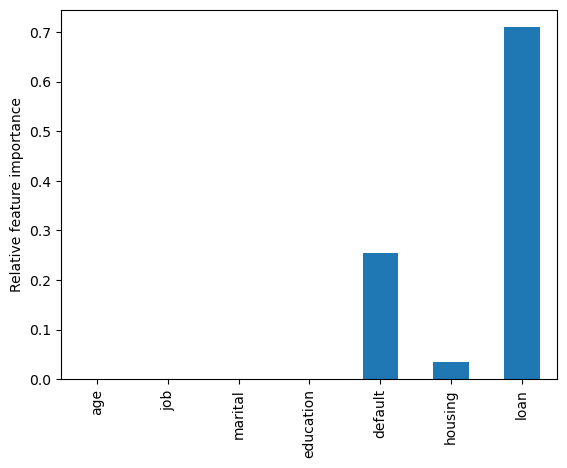

In [137]:
# Interpreting decision trees in terms feature importance
print(tree1.best_estimator_)
print(tree1.best_estimator_.feature_importances_)
importances = tree1.best_estimator_.feature_importances_
#indices = np.argsort(importances)
features = X_bal.columns
plt.title('Feature Importances for Decisision tree model(with test F1 score=96%)')
#plt.barh(range(len(indices)), importances, color='b', align='center')
#plt.yticks(range(len(indices)), features)
#plt.xlabel('Relative Importance')
#plt.show()
pd.Series(importances, index=features).plot(kind='bar')
plt.ylabel('Relative feature importance')

This plot shows that the most important features in the best perming decision trees model are Loan, followed by deault, and housing status of the client. This information can be used by banks to target clients for subscription.

##### Questions

Can the best model be improved by adding additional columns about call details and economic&social variables?

In [161]:
x_all=df.drop(columns=['y'])
x_all
y_all=df['y'].map({'no':0,'yes':1})

In [162]:
#Encode the data
encoder2=ce.LeaveOneOutEncoder(return_df=True)
X_all=encoder2.fit_transform(x_all,y_all)
X_all

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,0.100094,0.101577,0.102515,0.128794,0.108802,0.113405,0.052317,0.064352,0.099495,261,1,999,0,0.088325,1.1,93.994,-36.4,4.857,5191.0
1,57,0.081401,0.101577,0.108367,0.051536,0.108802,0.113405,0.052317,0.064352,0.099495,149,1,999,0,0.088325,1.1,93.994,-36.4,4.857,5191.0
2,37,0.081401,0.101577,0.108367,0.128794,0.116199,0.113405,0.052317,0.064352,0.099495,226,1,999,0,0.088325,1.1,93.994,-36.4,4.857,5191.0
3,40,0.129738,0.101577,0.082060,0.128794,0.108802,0.113405,0.052317,0.064352,0.099495,151,1,999,0,0.088325,1.1,93.994,-36.4,4.857,5191.0
4,56,0.081401,0.101577,0.108367,0.128794,0.108802,0.109332,0.052317,0.064352,0.099495,307,1,999,0,0.088325,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0.251891,0.101536,0.113316,0.128763,0.116153,0.113376,0.147343,0.101220,0.107973,334,1,999,0,0.088296,-1.1,94.767,-50.8,1.028,4963.6
41184,46,0.068951,0.101577,0.113506,0.128794,0.108802,0.113405,0.147382,0.101463,0.108101,383,1,999,0,0.088325,-1.1,94.767,-50.8,1.028,4963.6
41185,56,0.252472,0.101577,0.137257,0.128794,0.116199,0.113405,0.147382,0.101463,0.108101,189,2,999,0,0.088325,-1.1,94.767,-50.8,1.028,4963.6
41186,44,0.108128,0.101536,0.113316,0.128763,0.108748,0.113376,0.147343,0.101220,0.107973,442,1,999,0,0.088296,-1.1,94.767,-50.8,1.028,4963.6


<AxesSubplot:>

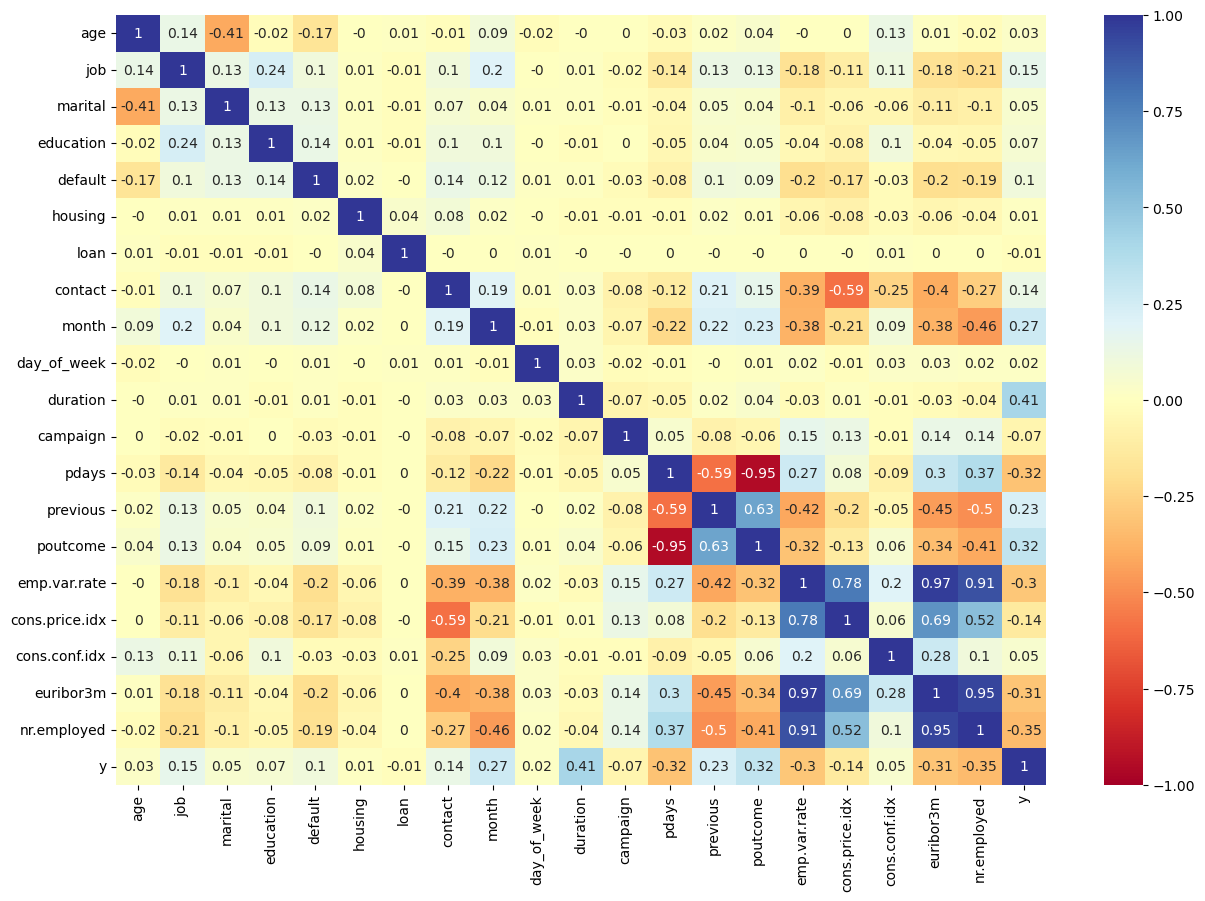

In [163]:
data=X_all
data['y']=y_all
plt.figure(figsize=(15,10))
sns.heatmap(round(data.corr(),2),vmin=-1,vmax=1,annot=True,cmap='RdYlBu')

In [164]:
X_all=X_all.drop(columns=['y'])

In [166]:
#drop columns correlated(>0.6) with others like emp.var.rate, nr.employed, euribor3m, poutcome, previous
X_all=X_all.drop(columns=['emp.var.rate','nr.employed', 'euribor3m','poutcome','previous'])
X_all

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,cons.price.idx,cons.conf.idx
0,56,0.100094,0.101577,0.102515,0.128794,0.108802,0.113405,0.052317,0.064352,0.099495,261,1,999,93.994,-36.4
1,57,0.081401,0.101577,0.108367,0.051536,0.108802,0.113405,0.052317,0.064352,0.099495,149,1,999,93.994,-36.4
2,37,0.081401,0.101577,0.108367,0.128794,0.116199,0.113405,0.052317,0.064352,0.099495,226,1,999,93.994,-36.4
3,40,0.129738,0.101577,0.082060,0.128794,0.108802,0.113405,0.052317,0.064352,0.099495,151,1,999,93.994,-36.4
4,56,0.081401,0.101577,0.108367,0.128794,0.108802,0.109332,0.052317,0.064352,0.099495,307,1,999,93.994,-36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0.251891,0.101536,0.113316,0.128763,0.116153,0.113376,0.147343,0.101220,0.107973,334,1,999,94.767,-50.8
41184,46,0.068951,0.101577,0.113506,0.128794,0.108802,0.113405,0.147382,0.101463,0.108101,383,1,999,94.767,-50.8
41185,56,0.252472,0.101577,0.137257,0.128794,0.116199,0.113405,0.147382,0.101463,0.108101,189,2,999,94.767,-50.8
41186,44,0.108128,0.101536,0.113316,0.128763,0.108748,0.113376,0.147343,0.101220,0.107973,442,1,999,94.767,-50.8


In [167]:
# Balance the data using SMOTE oversampler
oversampler2=SMOTE(random_state=42)
X_all_bal,y_all_bal=oversampler2.fit_resample(X_all,y_all)
X_all_bal

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,cons.price.idx,cons.conf.idx
0,56,0.100094,0.101577,0.102515,0.128794,0.108802,0.113405,0.052317,0.064352,0.099495,261,1,999,93.994000,-36.400000
1,57,0.081401,0.101577,0.108367,0.051536,0.108802,0.113405,0.052317,0.064352,0.099495,149,1,999,93.994000,-36.400000
2,37,0.081401,0.101577,0.108367,0.128794,0.116199,0.113405,0.052317,0.064352,0.099495,226,1,999,93.994000,-36.400000
3,40,0.129738,0.101577,0.082060,0.128794,0.108802,0.113405,0.052317,0.064352,0.099495,151,1,999,93.994000,-36.400000
4,56,0.081401,0.101577,0.108367,0.128794,0.108802,0.109332,0.052317,0.064352,0.099495,307,1,999,93.994000,-36.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73091,48,0.129046,0.101536,0.137391,0.128763,0.115935,0.109296,0.147343,0.211370,0.120952,200,1,6,93.710127,-34.372898
73092,38,0.099742,0.101536,0.137174,0.128763,0.112867,0.113376,0.147343,0.090339,0.107002,638,2,999,93.918000,-42.700000
73093,29,0.112827,0.139967,0.108262,0.128763,0.108748,0.113376,0.147343,0.090339,0.113558,720,2,999,93.918000,-42.700000
73094,75,0.251891,0.103015,0.102275,0.128763,0.116153,0.113376,0.147343,0.238381,0.102397,142,2,999,93.811598,-35.003406


In [168]:
# Split the data into train and test sets
X_train_bal2,X_test_bal2,y_train_bal2,y_test_bal2=train_test_split(X_all_bal,y_all_bal,test_size=0.20,stratify=y_all_bal,random_state=42)

In [169]:
# Normalize/scale the data
X_train_bal2=StandardScaler().fit_transform(X_train_bal2)
X_test_bal2=StandardScaler().fit_transform(X_test_bal2)

In [170]:
# Decision tree model with additional variables, but without hyperparameterization
%%time
tree_all=DecisionTreeClassifier(random_state=42).fit(X_train_bal2,y_train_bal2)

tree_train_f1_all=f1_score(y_train_bal2,tree_all.predict(X_train_bal2))
print(tree_train_f1_all)
tree_test_f1_all=f1_score(y_test_bal2,tree_all.predict(X_test_bal2))
print(tree_test_f1_all)

print(classification_report(y_test_bal2,tree_all.predict(X_test_bal2)))

1.0
0.9193233981009872
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      7310
           1       0.85      1.00      0.92      7310

    accuracy                           0.91     14620
   macro avg       0.93      0.91      0.91     14620
weighted avg       0.93      0.91      0.91     14620

Wall time: 279 ms


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
-----------
------------
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.14909933076964485
1.0
0.9193233981009872
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      7310
           1       0.85      1.00      0.92      7310

    accuracy                           0.91     14620
   macro avg       0.93      0.91      0.91     14620
weighted avg       0.93      0.91      0.91     14620

0.9122435020519836


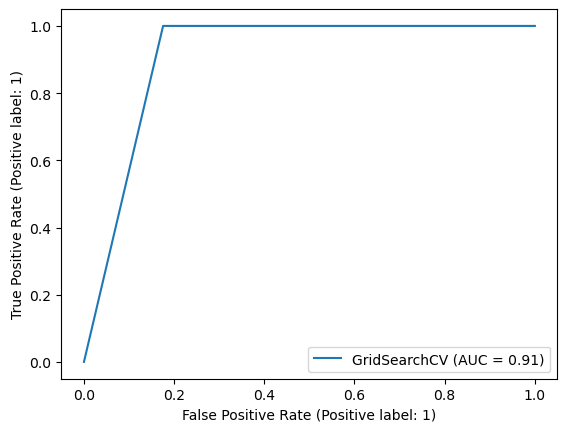

In [176]:
# Decision tree model with additional variables, and with hyperparameterization using GridSearchCV
%%time
params = {'max_depth': range(1,10),
         'min_samples_split': [2,4,6,8],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [2,3,4]
         }
tree2= GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring = 'f1',\
                    cv=5,\
                    verbose = 1,\
                    return_train_score = True).fit(X_train_bal2, y_train_bal2)
print('-----------')
#print(tree2.cv_results_)
print('------------')
print(tree2.best_params_)
#Mean fit time
print(np.mean(tree2.cv_results_['mean_fit_time']))
#F-1 scores for train and test data
print(tree2.score(X_train_bal2,y_train_bal2))
print(tree2.score(X_test_bal2,y_test_bal2))
#Classification report
print(classification_report(y_test_bal2, tree2.predict(X_test_bal2)))
# ROC curve and AUC
plot_roc_curve(tree2, X_test_bal2, y_test_bal2)
print(roc_auc_score(y_test_bal2, tree2.predict_proba(X_test_bal2)[:, 1]))

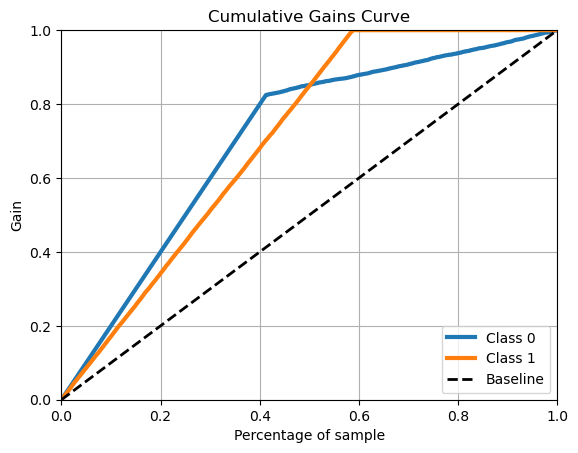

In [177]:
skplt.metrics.plot_cumulative_gain(y_test_bal2, tree2.predict_proba(X_test_bal2))
plt.show()

This decision tree model with additional variables related to call information and economic&social indices performed well and has a test score of 91% and ROC AUC of 0.91.

However it still did not outperform the hyperparateterized decision tree model from earlier which had a test score of 96% and ROC AUC of 0.959. 

In terms of cumulative gains, this model shows that sampling 50% of the clients could get 85% subsribers, while the previous best performing decision tree model showed a somewhat higher value of approximately 95% subsribers.

**Recommendations and Next steps**

The most important features for whether or not a contact would subsribe to the deposit are housing, default, and loan charactersttics of the contact/client.

This is found with the best performing model called decision trees which has a test score (F-1 score) of 96%. ROC area under the curve for this model is also high, about 0.96. Cumulative gains curve shows that for the best perfroming model, with sampling just 50% of the clients/contacts, it is possible to net about 95% term subscribers.

Next steps would involve running more efficient models that are popular in the machine learning world today to see if the accuracy or performance metrics improve. this would involve classifiers like Extreme Gradient Boosting Classifier, Native Bayes Classifier, and especially the Random Forests Classifier (as it is uses a combination of several decision trees and can perhaps be better than the single decision tree used here).